### Описание проекта

Цель проекта - сегментировать покупателей интернет-магазина товаров для дома и быта по профилю потребления для разработки более персонализированных предложений для покупателей.

Заказчик - продакт-менеджер компании.

Задачи:

* Провести исследовательский анализ данных
* Сегментировать покупателей на основе истории их покупок
* Сформулировать и проверить статистические гипотезы

### Описание данных

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в  *ecommerce_dataset.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

### Шаг 1. Загрузка данных

#### 1. Импорт библиотек

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
import warnings
import scipy.stats as stats
import numpy as np
from scipy import stats as st

warnings.filterwarnings('ignore')

#### 2. Импорт данных

In [48]:
data = pd.read_csv("ecommerce_dataset.csv")
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


### Шаг 2. Исследовательский анализ данных

#### 1. Изучить информацию о таблице

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Таблица содержит 6737 записей. Проверим чистоту данных и поработаем со столбцом date, приведя его к нужному формату.

#### 2. Проверить чистоту данных (дубли, пропуски, типы данных, наименования колонок)

In [50]:
print('Количество дубликатов в таблице data: ', data.duplicated().sum())
print('Количество пропусков в таблице data: ', data.isnull().sum().sum())

Количество дубликатов в таблице data:  0
Количество пропусков в таблице data:  0


Пропусков в таблице не обнаружено, полных дубликатов тоже. Проверим данные на наличие неявных дубликатов.

Для начала посмотрим, есть ли в таблице заказы с одним номером, но разными покупателями.

In [51]:
data.groupby(['order_id']).agg({'customer_id': ['nunique']})['customer_id'].value_counts()

nunique
1          2755
2            26
3             2
4             1
Name: count, dtype: int64

Видим, что у нас есть: 
 * 1 заказ с 4 разными покупателями
 * 2 заказа с 3 разными покупателями
 * 26 заказов с 2 разными покупателями
 
Рассмотрим эти случаи детальнее.

In [52]:
(data.groupby(['order_id']).agg({'customer_id': ['nunique']})['customer_id']).sort_values(by='nunique').tail()

,nunique
order_id,
69310,2
71461,2
69485,3
71480,3
72845,4


In [53]:
data[data['order_id'] == 72845]

,date,customer_id,order_id,product,quantity,price
6504,2019100314,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6505,2019100315,0309d37c-ab5f-4793-ba72-5484c019b840,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6508,2019100408,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6538,2019100720,2ac05362-3ca7-4d19-899c-7ba266902611,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0


Заказ 72845 абсолютно идентичен по составу, но оформлен покупателями с разным ID в разное время. Скорее всего, это связано с тем, что один и тот же заказ по тем или иным причинам переоформлялся несколько раз на разные даты (возможно, менялись условия доставки, способ оплаты или что-то ещё). Исходя из этого примем решение оставить только последнюю, самую новую, запись о заказе, считая её актуальной.

In [54]:
data[data['order_id'] == 71480]

,date,customer_id,order_id,product,quantity,price
3963,2019052102,4bd9c1e8-b2cc-4ec5-97eb-28d8f3c22d8d,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0
4025,2019052422,d8080f8f-3685-433b-b416-beb0a8f06606,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0
4026,2019052502,51f04abe-a71a-4694-87b7-ad9ef4930e51,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0


In [55]:
data.groupby(['order_id']).agg({'date': ['nunique']})['date'].value_counts()

nunique
1          2500
2           189
3            53
4            17
5             8
6             4
7             4
9             2
8             1
10            1
12            1
16            1
23            1
60            1
74            1
Name: count, dtype: int64

Видим много заказов с разными данными. Рассмотрим детальнее.

In [56]:
(data.groupby(['order_id']).agg({'date': ['nunique']})['date']).sort_values(by='nunique').tail()

,nunique
order_id,
69531,12
71148,16
69162,23
70960,60
14833,74


In [57]:
data[data['order_id'] == 14833].head()

,date,customer_id,order_id,product,quantity,price
4157,2019053112,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Аэронавт, кассета по 6шт",1,120.0
4158,2019053112,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Белогор кассета 6 шт E6,1,120.0
4159,2019053112,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Горный, кассета по 6шт",1,120.0
4160,2019053112,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Зебра кассета 6 шт E6,1,120.0
4161,2019053112,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Золотинка кассета 6 шт E6,1,120.0


In [58]:
data[data['order_id'] == 69531].head()

,date,customer_id,order_id,product,quantity,price
1323,2018122314,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo...,1,4139.0
1338,2018122408,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo...,1,4139.0
1417,2018122823,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo...,1,4139.0
1422,2019010110,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo...,1,4139.0
1429,2019010308,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo...,1,4139.0


На примере двух рассмотренных заказов видим, что каждый из них был оформлен одним покупателем. В первом случае (заказ 14833) менялись товары в заказе, во втором (заказ 69531) менялась только дата. Можно сделать вывод о том, что покупатели по каким-то причинам несколько раз обновляли состав заказа или иные сведения о нём. 

Проанализировав разные виды скрытых дубликатов, примем решение для всех заказов, имеющих разные даты или разных покупателей, оставить в таблице только те, что были оформлены последними.

In [59]:
data = data.drop_duplicates(subset=['order_id', 'product'], keep='last')

Приведём столбец data к нужному формату и в отдельный столбец выделим время.

In [60]:
data['hour'] = data['date'].apply(lambda x: f'{str(x)[8:]}:00')
data['date'] = data['date'].apply(lambda x: str(x)[:8])
data['date'] = pd.to_datetime(data['date'], format = '%Y%m%d')
data['day'] = data['date'].dt.day_name()
data['month'] = data['date'].dt.month_name()
data['year'] = data['date'].dt.year
data.head()

,date,customer_id,order_id,product,quantity,price,hour,day,month,year
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,00:00,Monday,October,2018
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,00:00,Monday,October,2018
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,00:00,Monday,October,2018
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,00:00,Monday,October,2018
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,00:00,Monday,October,2018


#### 3. Выделить основные показатели интернет-магазина и изучить их динамику:
* выручка
* средний чек
* средняя выручка с покупателя
* другие показатели    

In [61]:
data['date'].min()

Timestamp('2018-10-01 00:00:00')

In [62]:
data['date'].max()

Timestamp('2019-10-31 00:00:00')

Данные содержат информацию о покупках с 10 октября 2018 года по 31 октября 2019 года.

In [63]:
len(data['customer_id'].unique())

2422

In [64]:
len(data['order_id'].unique())

2784

Данные содержат информацию о 2451 покупателе и 2784 заказах.

#### Динамика выручки

Месяцы и часы в исходных данных идут не попорядку, поэтому подготовимся к построению графиков, чтобы всё было в нужном порядке.

In [65]:
month = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December'
 ]

hours = ['00:00',
 '01:00',
 '02:00',
 '03:00',
 '04:00',
 '05:00',
 '06:00',
 '07:00',
 '08:00',
 '09:00',
 '10:00',
 '11:00',
 '12:00',
 '13:00',
 '14:00',
 '15:00',
 '16:00',
 '17:00',
 '18:00',
 '19:00',
 '20:00',
 '21:00',
 '22:00',
 '23:00'
 ]

days_of_week = ['Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday'
 ]

seasons = ['зима',
 'весна',
 'лето',
 'осень'
 ]

In [66]:
data['cost'] = data['price'] * data['quantity']
data_by_month = data.groupby(['month', 'year'])['cost'].sum().reset_index()
data_by_month

,month,year,cost
0,April,2019,316691.0
1,August,2019,181231.0
2,December,2018,345475.0
3,February,2019,306059.0
4,January,2019,234715.0
5,July,2019,226361.0
6,June,2019,910319.0
7,March,2019,255704.0
8,May,2019,230806.0
9,November,2018,359772.0


In [67]:
data[['product', 'cost']].groupby('product').sum().sort_values('cost', ascending=False).head(10)

,cost
product,
"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",675000.0
Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,53232.0
Сумка-тележка 2-х колесная Gimi Argo синяя,50405.0
Вешалки мягкие для деликатных вещей 3 шт шоколад,49596.0
Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,33992.0
Муляж ЯБЛОКО 9 см красное,32702.0
Набор ножей Attribute CHEF 5 предметов AKF522,29248.0
"Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90",28045.0
"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь",24370.0


В таблице выше видим топ-10 товаров, продажа которых принесла магазину наибольшую прибыль за период наблюдений. На первом месте с явным опережением видим вантуз с деревянной ручкой. 

In [68]:
data.query('cost == 675000')

,date,customer_id,order_id,product,quantity,price,hour,day,month,year,cost
5456,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,15:00,Tuesday,June,2019,675000.0


Видим, что все эти вантузы были куплены в одном заказе. Этот заказ являлся тестовым, поэтому можем удалить его из таблицы.

In [69]:
data = data.query('cost != 675000')

Обновим информацию о количестве исследуемых заказов:

In [70]:
len(data['order_id'].unique())

2783

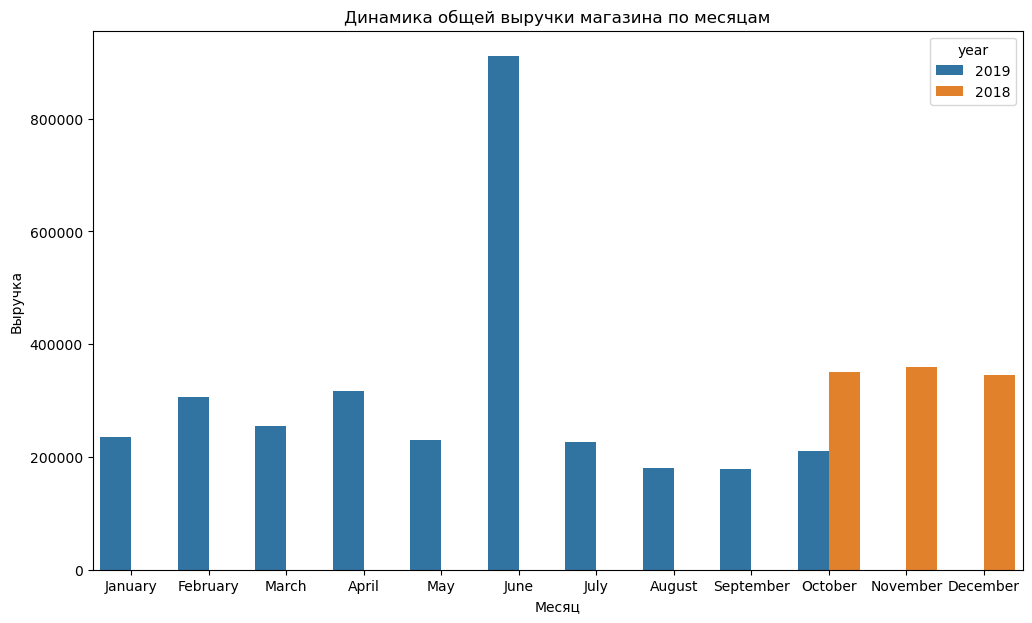

In [71]:
plt.figure(figsize=(12, 7))
data_by_month['year'] = data_by_month['year'].astype(str)
sns.barplot(x = 'month', y = 'cost', hue = 'year', order =  month, data = data_by_month).set(title='Динамика общей выручки магазина по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

На графике динамики общей выручки магазина по месяцам видим резкий подъём в июне 2019, спады в августе и сентябре. Таже видим, что в октябре 2019 выручка оказалась меньше, чем в октябре 2018. В целом, если не брать в расчёт аномальный июнь, есть ощущение что в 2018 выручка была несколько выше, чем в 2019.

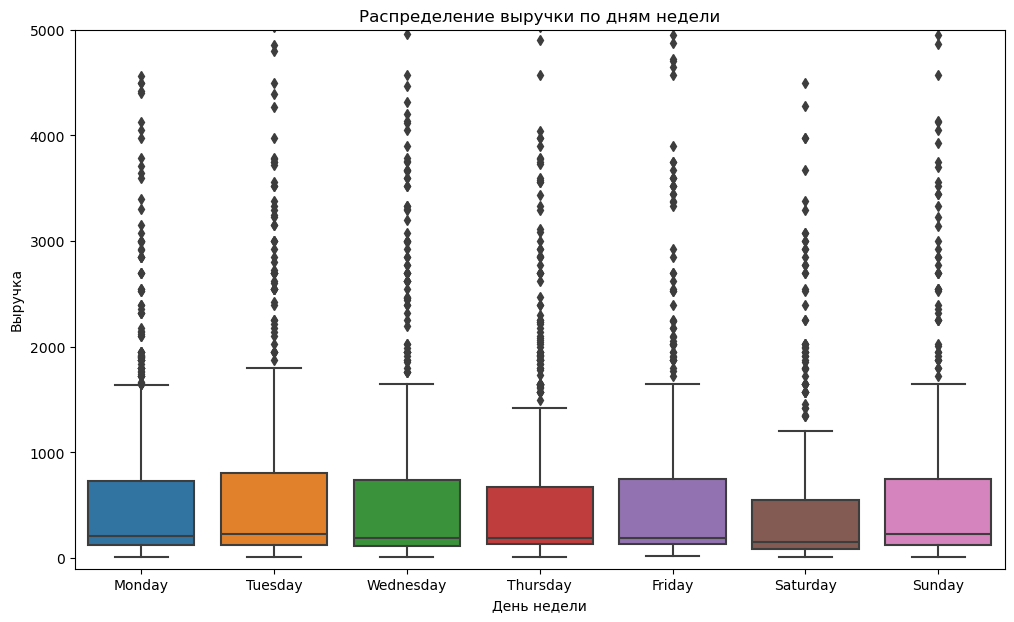

In [72]:
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='day', y='cost', data=data)
ax.set_ylim(-100, 5000)
plt.xlabel('День недели')
plt.ylabel('Выручка')
plt.title('Распределение выручки по дням недели')
plt.show()

На графике распределения выручки по дням недели можем наблюдать заметный спад показателей в субботу.

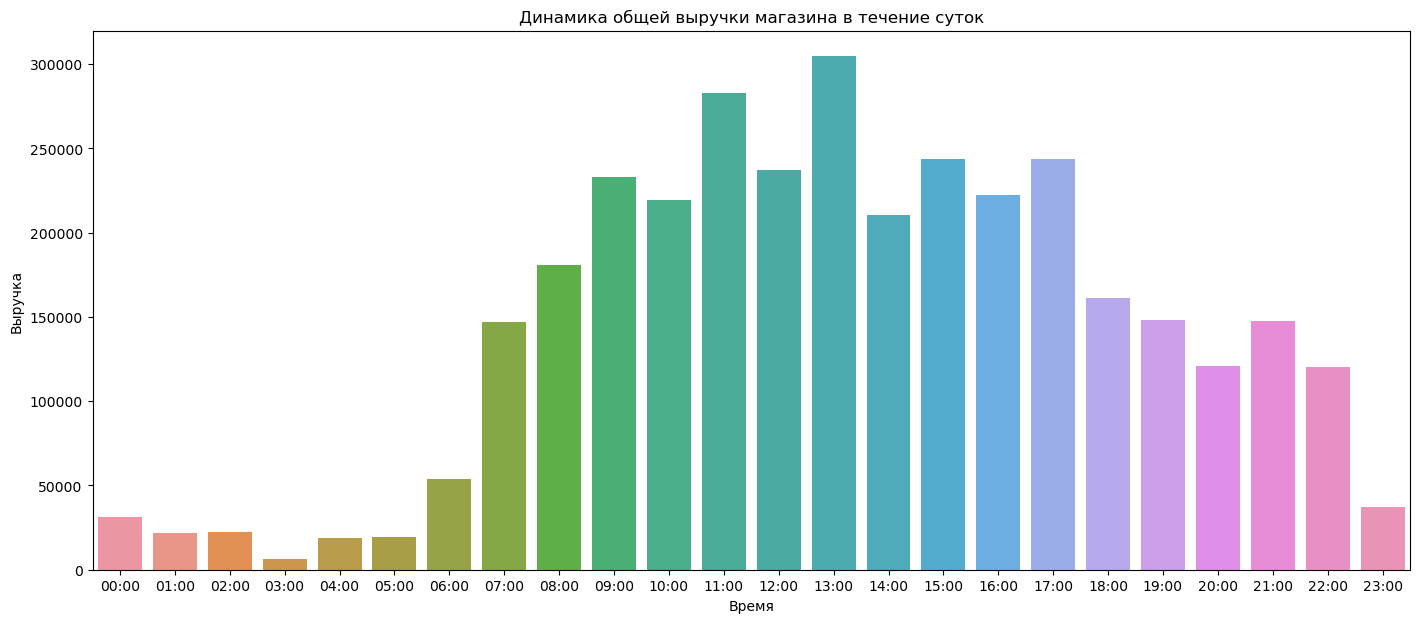

In [73]:
plt.figure(figsize=(17, 7))
sns.barplot(x = 'hour', y = 'cost', order =  hours, data = data.groupby(['hour'])['cost'].sum().reset_index()).set(title='Динамика общей выручки магазина в течение суток')
plt.xlabel('Время')
plt.ylabel('Выручка')
plt.show()

На графике суточной динамики выручки наблюдаем закономерный минимум в ночные часы (с 23 до 7 утра). Самое прибыльное время - с 9.00 до 18:00 с максимумом в 13 часов.

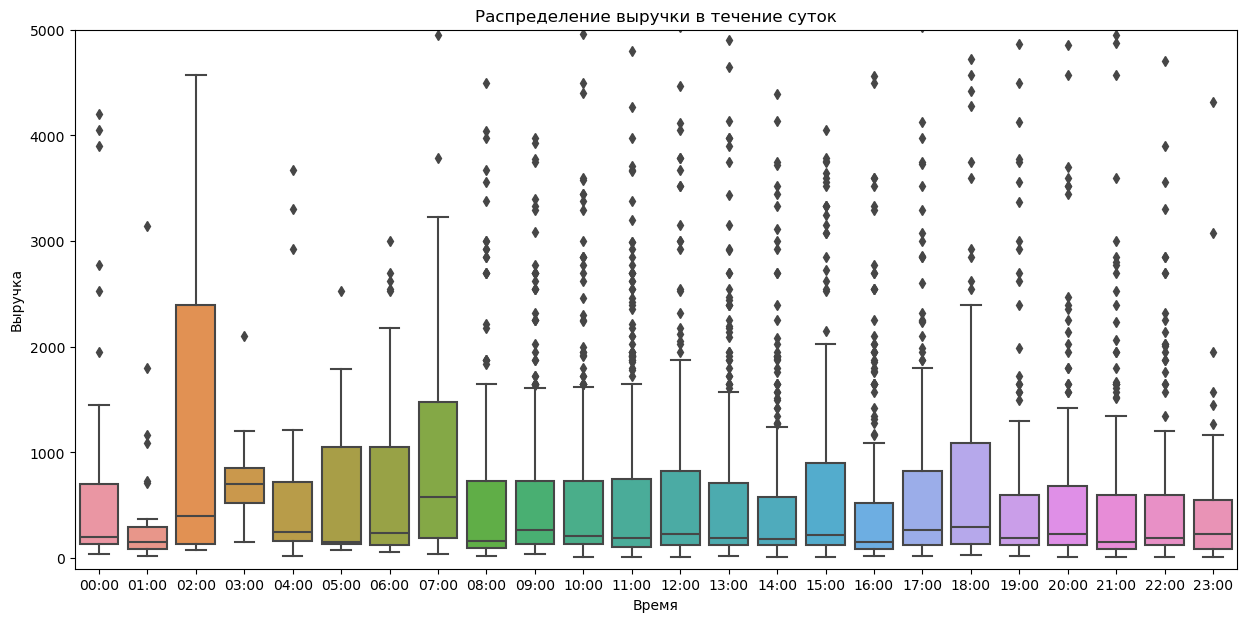

In [74]:
plt.figure(figsize=(15, 7))
ax = sns.boxplot(x='hour', y='cost', order =  hours, data=data)
ax.set_ylim(-100, 5000)
plt.xlabel('Время')
plt.ylabel('Выручка')
plt.title('Распределение выручки в течение суток')
plt.show()

По графику распределения выручки по времени видим пики значений медианной выручки в 3 и 7 часов. Вероятно, причина заключается в том, что в эти часы заказов было мало и они имели относительно высокую стоимость. В другие часы незначительные пики можно выделить в 15 и 18 часов.

In [75]:
def season(column):
    if column['month'] in {'December', 'January', 'February'}:
        return 'зима'
    if column['month'] in {'March', 'April', 'May'}:
        return 'весна'
    if column['month'] in {'June', 'July', 'August'}:
        return 'лето'    
    return 'осень'

data['season'] = data.apply(season, axis=1)

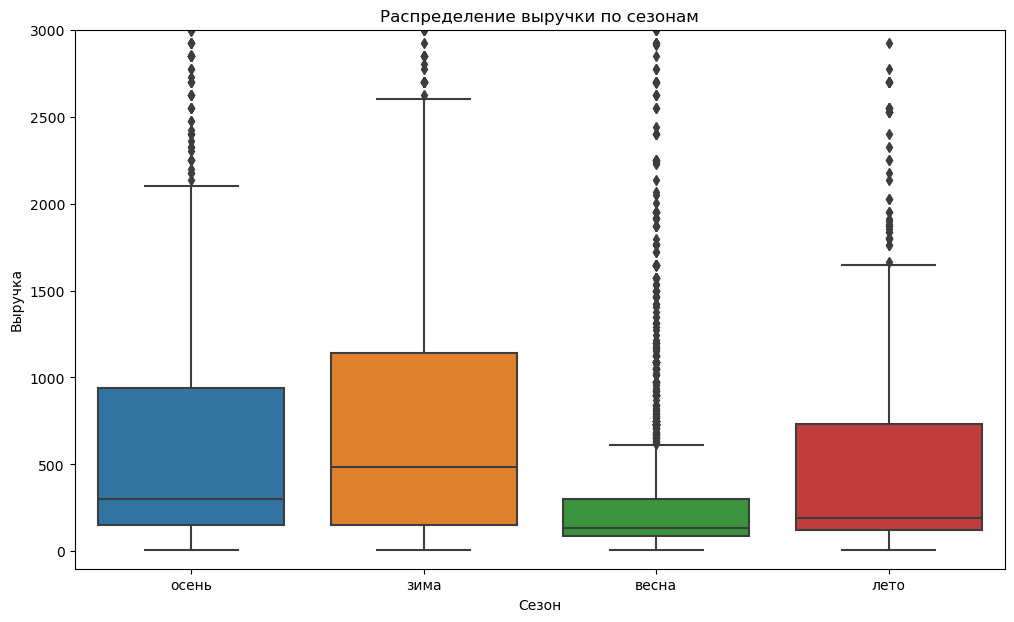

In [76]:
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='season', y='cost', data=data)
ax.set_ylim(-100, 3000)
plt.xlabel('Сезон')
plt.ylabel('Выручка')
plt.title('Распределение выручки по сезонам')
plt.show()

Что касается выручки по сезонам, наибольшую среднюю выручку принесли заказы, сделанные зимой. Затем по убыванию идут осень, лето и весна.

In [77]:
cost_by_customer = data.groupby(['month', 'year', 'customer_id'])['cost'].sum().reset_index()
cost_by_customer

,month,year,customer_id,cost
0,April,2019,0184f535-b60a-4914-a982-231e3f615206,3103.0
1,April,2019,01f95d43-4a8d-45e5-9c23-cccd211e6d30,44.0
2,April,2019,02adb72a-3067-45e9-a3b5-f93d79d7496a,10723.0
3,April,2019,03134fa3-9ce0-4973-849d-32c21e26d64e,1177.0
4,April,2019,059d1900-8450-47b0-b914-e5744cea5017,1222.0
...,...,...,...,...
2465,September,2019,faca2263-add0-430d-b0ba-fce720fa9cf3,74.0
2466,September,2019,fc4b5242-d331-4643-951d-90d2d4fe0382,134.0
2467,September,2019,fc4fa65e-98e3-41b9-a1eb-988c6754b3be,74.0
2468,September,2019,fd4bc7b8-6ad6-4077-8e63-3593ab5e1cfd,1087.0


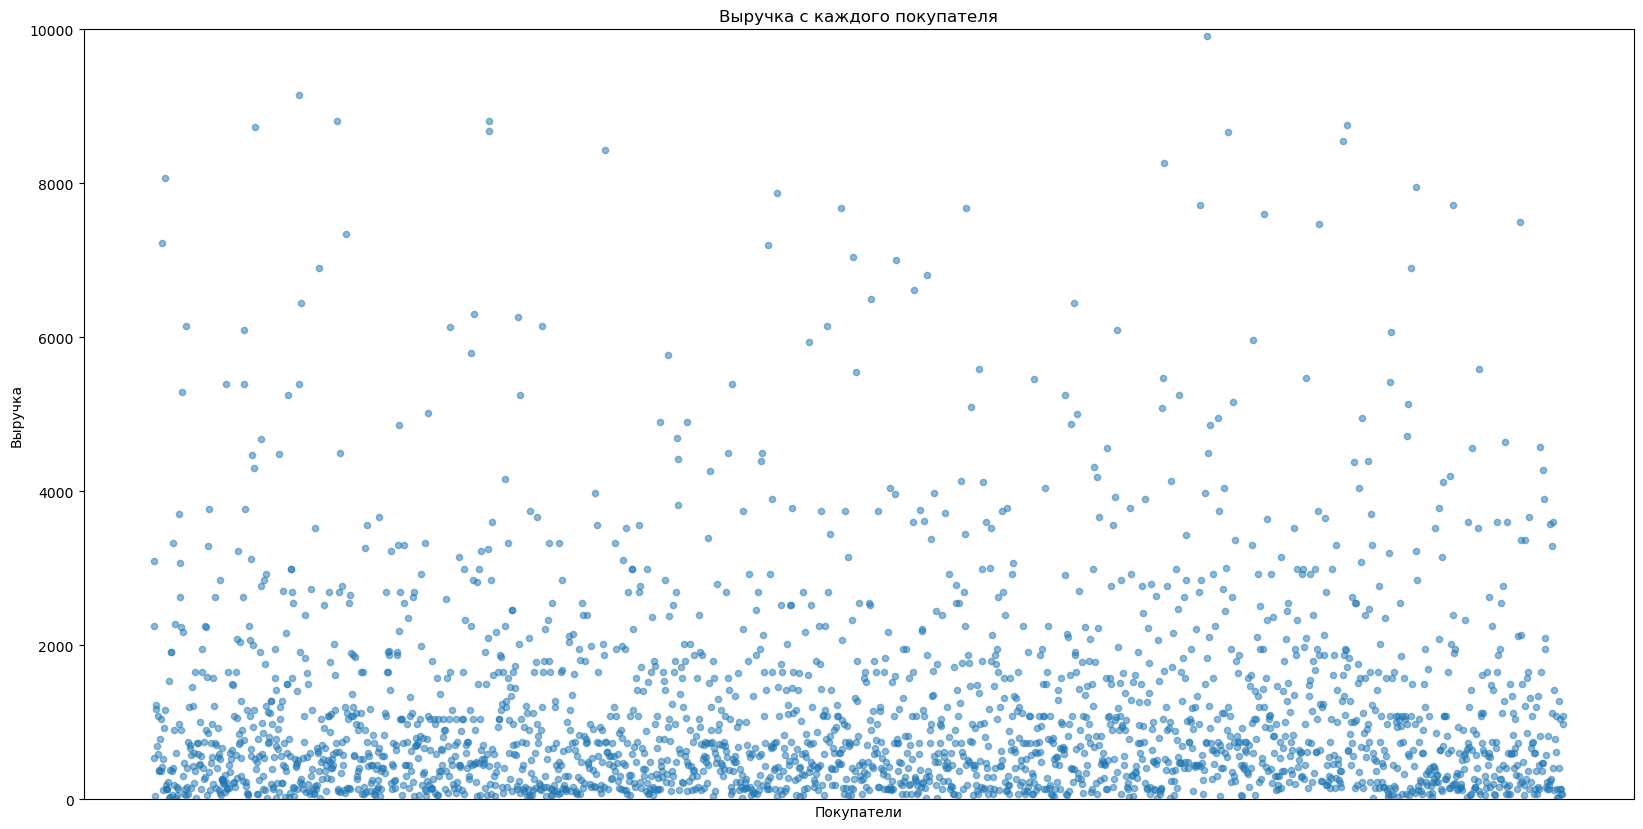

In [78]:
ax = cost_by_customer[['customer_id', 'cost']].plot(x='customer_id', y='cost', kind='scatter', alpha=0.5, figsize=(20,10))
ax.set_ylim(0, 10000)
plt.xlabel('Покупатели')
plt.ylabel('Выручка')
plt.title('Выручка с каждого покупателя')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

Большинство пользователей приносят магазину выручку до 2000 у.е.

#### Динамика количества заказов

AttributeError: 'numpy.int32' object has no attribute 'startswith'

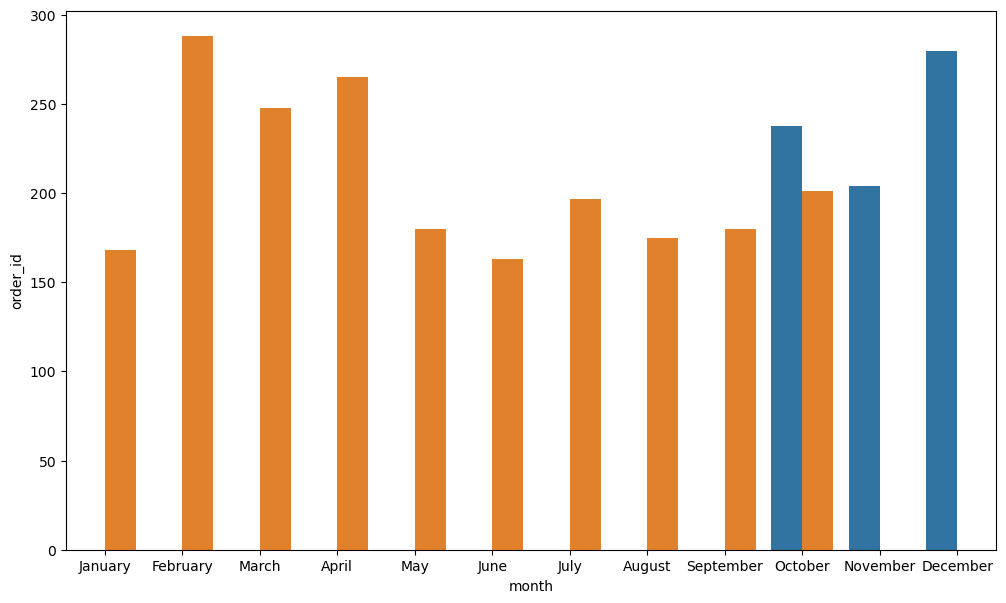

In [79]:
plt.figure(figsize=(12, 7))
sns.barplot(x = 'month', y = 'order_id', hue = 'year', order =  month, data = data.groupby(['month', 'year'])['order_id'].nunique().reset_index()).set(title='Динамика количества заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Больше всего заказов было сделано в феврале 2019 и декабре 2018. Ярко выраженные спады видим в январе, мае, июне, августе и сентябре 2019. Единственный месяц, по которому можем сравнить с предыдущим годом - октябрь, и в октябре 2018 количество заказов было  выше чем в аналогичном месяце следующего года.

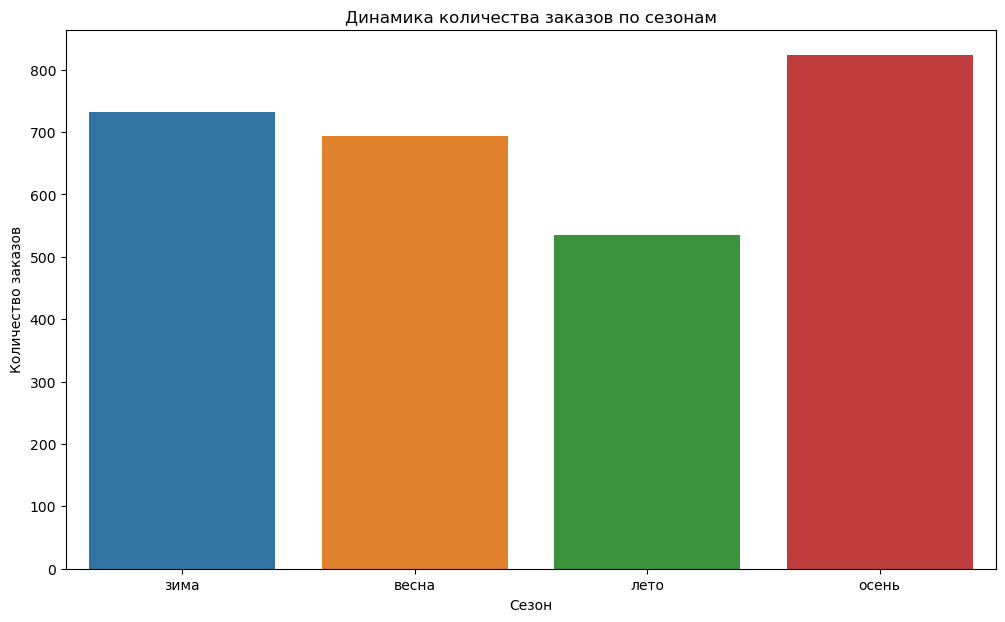

In [80]:
plt.figure(figsize=(12, 7))
sns.barplot(x = 'season', y = 'order_id', order = seasons, data = data.groupby(['season'])['order_id'].nunique().reset_index()).set(title='Динамика количества заказов по сезонам')
plt.xlabel('Сезон')
plt.ylabel('Количество заказов')
plt.show()

Больше всего заказов сделали осенью. Минимум - летом.

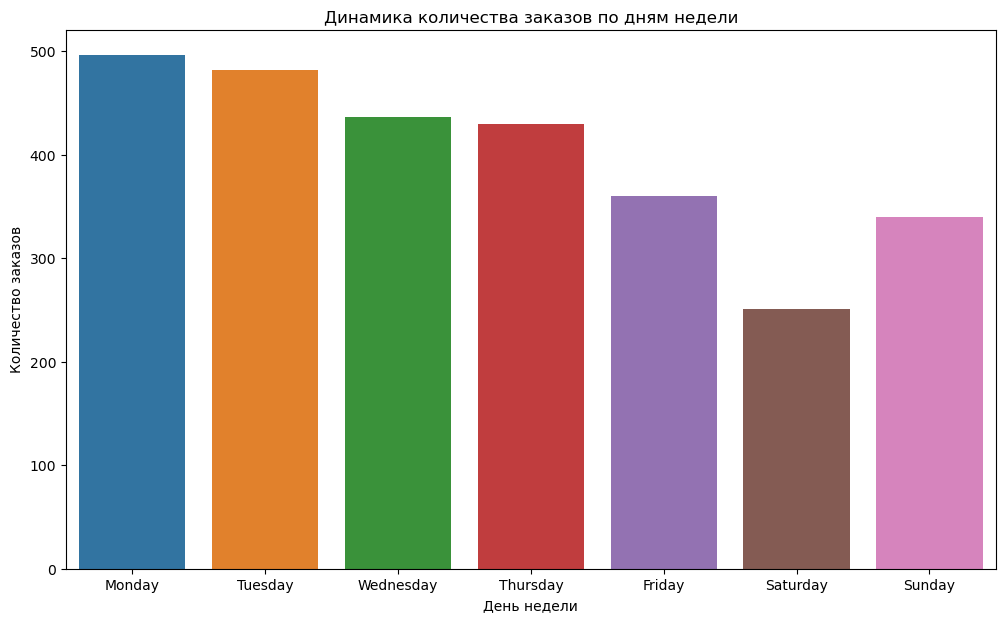

In [81]:
plt.figure(figsize=(12, 7))
sns.barplot(x = 'day', y = 'order_id', order =  days_of_week, data = data.groupby(['day'])['order_id'].nunique().reset_index()).set(title='Динамика количества заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.show()

Активность покупателей максимальна в понедельник и постепенно снижается к выходным, достигая заметного минимума в субботу.

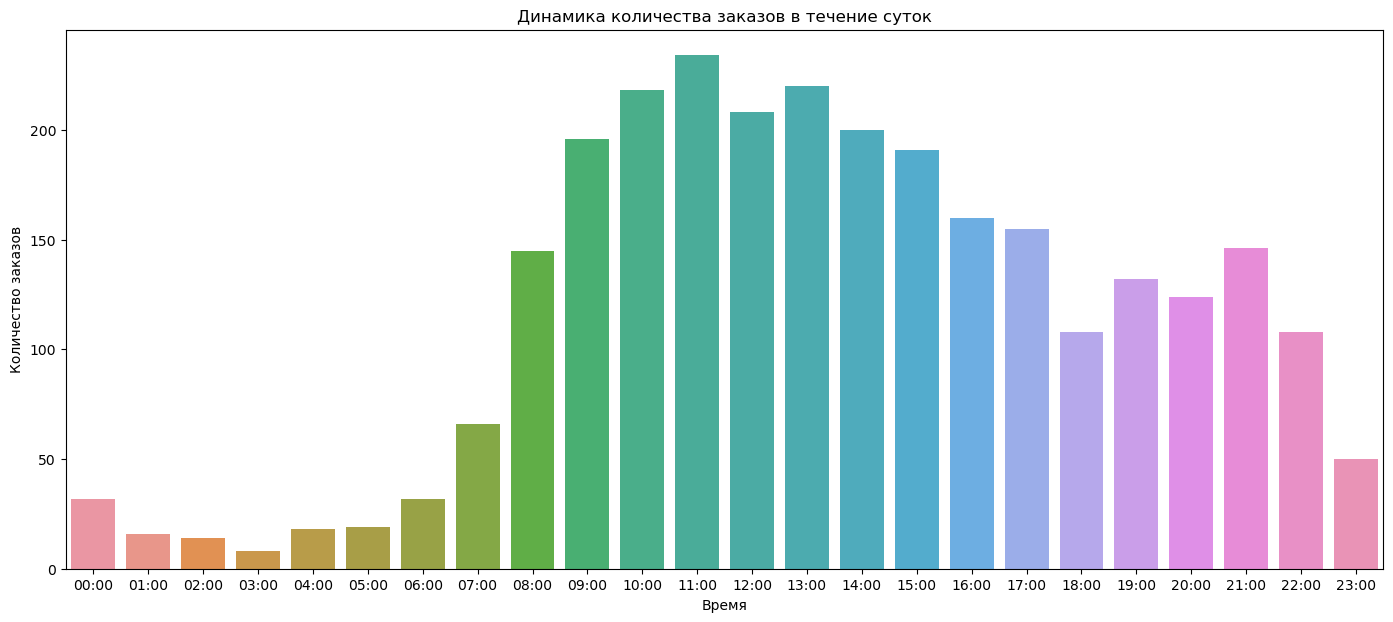

In [82]:
plt.figure(figsize=(17, 7))
sns.barplot(x = 'hour', y = 'order_id', order =  hours, data = data.groupby(['hour'])['order_id'].nunique().reset_index()).set(title='Динамика количества заказов в течение суток')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

Наиболее активно пользователи совершают заказы в первой половине дня (с 9 до 15) с пиком в 11 часов.

#### Другие показатели интернет-магазина

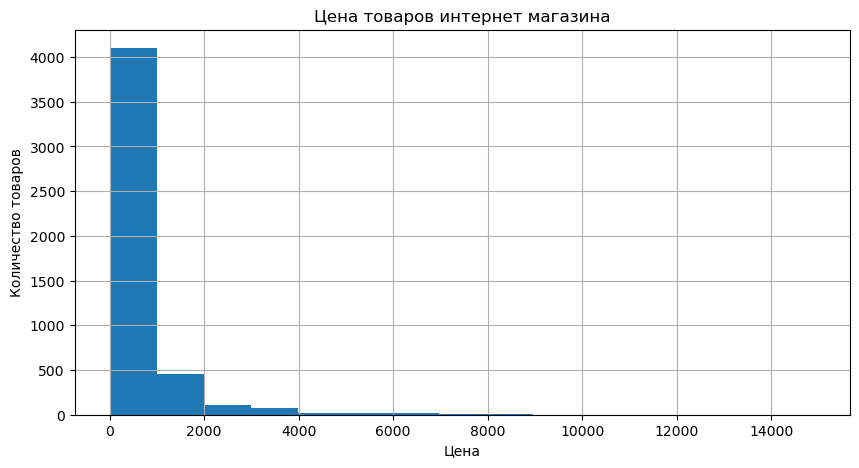

In [83]:
data['price'].hist(figsize=(10, 5), bins = 15)
plt.xlabel('Цена')
plt.ylabel('Количество товаров')
plt.title('Цена товаров интернет магазина')
plt.show()

Стоимость большинства товаров магазина не превышает 1000 у.е.

In [84]:
data[['product', 'cost']].groupby('product').sum().sort_values('cost', ascending=False).head(10)

,cost
product,
Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,53232.0
Сумка-тележка 2-х колесная Gimi Argo синяя,50405.0
Вешалки мягкие для деликатных вещей 3 шт шоколад,49596.0
Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,33992.0
Муляж ЯБЛОКО 9 см красное,32702.0
Набор ножей Attribute CHEF 5 предметов AKF522,29248.0
"Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90",28045.0
"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь",24370.0
"Веник сорго с деревянной ручкой с 4-мя швами, Rozenbal, R206204",20010.0


In [85]:
data[['product', 'cost']].groupby('product').sum().sort_values('cost', ascending=False).head(10)

,cost
product,
Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,53232.0
Сумка-тележка 2-х колесная Gimi Argo синяя,50405.0
Вешалки мягкие для деликатных вещей 3 шт шоколад,49596.0
Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,33992.0
Муляж ЯБЛОКО 9 см красное,32702.0
Набор ножей Attribute CHEF 5 предметов AKF522,29248.0
"Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90",28045.0
"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь",24370.0
"Веник сорго с деревянной ручкой с 4-мя швами, Rozenbal, R206204",20010.0


In [86]:
data[['product', 'quantity']].groupby('product').sum().sort_values('quantity', ascending=False).head(10)

,quantity
product,
Муляж ЯБЛОКО 9 см красное,618
Вешалки мягкие для деликатных вещей 3 шт шоколад,335
"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200
Муляж Яблоко зеленый 9 см полиуретан,188
"Крепеж для пружины дверной, 1107055",170
Плечики пластмассовые Размер 52 - 54 Тула 1205158,160
"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150
Муляж Банан желтый 21 см полиуретан,109
"Щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096",105


В таблице выше видим топ-10 товаров по количеству проданных единиц за исследуемый период.

Посмотрим на топ-5 клиентов, принесших максимальную выручку магазину:

In [87]:
data[['customer_id', 'cost']].groupby('customer_id').sum().sort_values('cost', ascending=False).head()

,cost
customer_id,
c971fb21-d54c-4134-938f-16b62ee86d3b,159508.0
4d93d3f6-8b24-403b-a74b-f5173e40d7db,57278.0
58a4c3cc-504f-43ea-a74a-bae19e665552,53232.0
146cd9bf-a95c-4afb-915b-5f6684b17444,49432.0
498f12a4-6a62-4725-8516-cf5dc9ab8a3a,41900.0


5 клиентов, принесших минимальную выручку:

In [88]:
data[['customer_id', 'cost']].groupby('customer_id').sum().sort_values('cost', ascending=False).tail()

,cost
customer_id,
2b6439c9-1ae1-4785-9509-ca4348b3d39a,22.0
55b8d928-77f8-40fc-a2e9-08424d13b0e4,22.0
f32b5708-af61-42e7-baba-9f3759d87841,15.0
2330d859-e9cb-4c8f-abd0-55f9e27e6745,15.0
cab090a5-b8dd-442d-a206-0ef3bf5fc1d8,14.0


In [89]:
data_bill = data.groupby(['month', 'year', 'order_id'])['cost'].sum().reset_index()
data_bill

,month,year,order_id,cost
0,April,2019,14606,1215.0
1,April,2019,14608,1276.0
2,April,2019,14611,1140.0
3,April,2019,14612,2723.0
4,April,2019,14614,1759.0
...,...,...,...,...
2782,September,2019,72805,1124.0
2783,September,2019,72806,74.0
2784,September,2019,72810,157.0
2785,September,2019,72811,4560.0


AttributeError: 'numpy.int32' object has no attribute 'startswith'

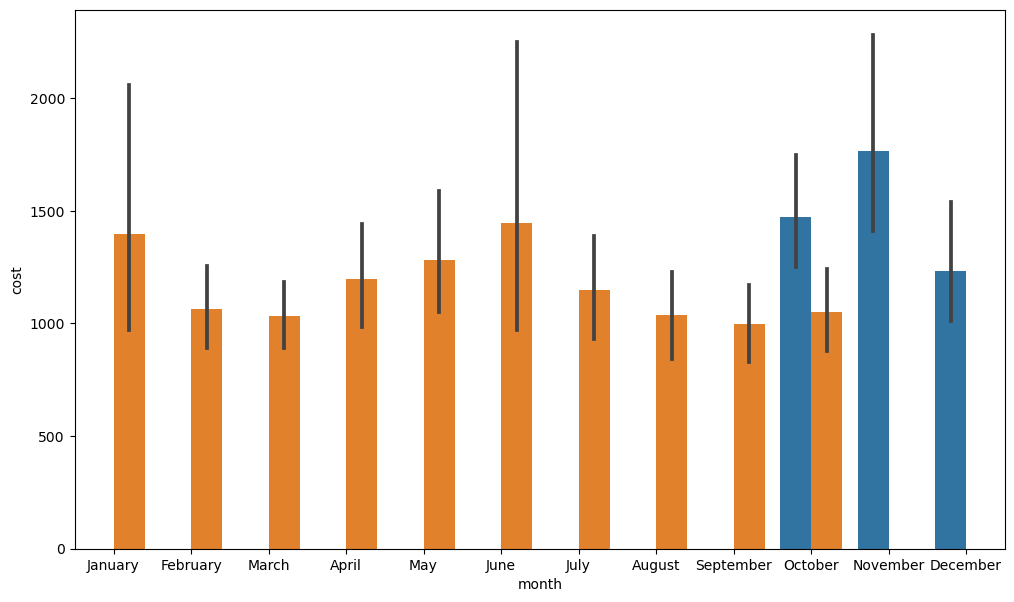

In [90]:
plt.figure(figsize=(12, 7))
sns.barplot(x = 'month', y = 'cost', hue = 'year', order =  month, data = data_bill).set(title='Динамика чека')
plt.xlabel('Месяц')
plt.ylabel('Чек')
plt.show()

На графике видим динамику среднего чека по месяцам. Максимальное значение - в ноябре 2018. Также высокие значения в январе и июне 2019 и в октябре 2018. Минимальные значения - в августе и сентябре.

#### 4. Сделать выводы о текущей ситуации: какие есть проблемы и сильные стороны в состоянии дел магазина?

Исследуемые данные содержат информацию о 2451 покупателе и 2783 заказах в период с 10 октября 2018 года по 31 октября 2019 года.<br>
Стоимость большинства товаров магазина не превышает 1000 у.е.<br>Большинство пользователей приносят магазину выручку до 2000 у.е.<br>

Больше всего заказов было сделано в феврале 2019 и декабре 2018. Ярко выраженные спады видим в январе, мае, июне, августе и сентябре 2019. Единственный месяц, по которому можем сравнить с предыдущим годом - октябрь, и в октябре 2018 количество заказов было выше чем в аналогичном месяце следующего года.<br>
Наиболее активно пользователи совершают заказы в первой половине дня (с 9 до 15) с пиком в 11 часов.<br>
Активность покупателей максимальна в понедельник и постепенно снижается к выходным, достигая заметного минимума в субботу.<br>
Больше всего заказов сделали осенью. Минимум - летом. 


В динамике общей выручки магазина по месяцам видим резкий подъём в июне 2019, спады в августе и сентябре. Таже видим, что в октябрe 2019 выручка оказалась меньше, чем в октябре 2018. В целом, если не брать в расчёт аномальный июнь, есть ощущение что в 2018 выручка была несколько выше, чем в 2019.<br>
Из всех дней недели наименее прибыльным стала суббота.
Что касается выручки по сезонам, наибольшую среднюю выручку имели заказы, сделанные зимой. Затем по убыванию идут осень, лето и весна.<br>


Максимальное значение среднего чека - в ноябре 2018. Также высокие значения в январе и июне 2019 и в октябре 2018. Минимальные значения - в августе и сентябре 2019.<br>

Говоря о проблемах, можно выделить неравномерность потока клиентов и выручки в течение года. Самым прибыльным месяцем стал июнь 2019. Ярко выраженный спад наблюдаем в августе и сентябре. Также можно сделать вывод о том, что большинство покупателей совершают небольшие заказы: большинство товаров в магазине стоят до 1000 у.е., а средний чек редко превышал 1500 у.е. Исключение - июнь 2019. Также неравномерен поток клиентов в течение недели: от максимума в понедельник до минимума в выходные.

Данных для сравнения динамики по годам не достаточно, но глядя на единственный месяц, по которому есть данные за оба года - октябрь - видим, что по сравнению с 2018 в октябре 2019 количество заказов и выручка заметно сократились.


### Шаг 3. Сегментация покупателей на основе истории их покупок

#### 1. Определить критерии сегментации таким образом, чтобы сегментация помогла в разработке более персонализированных предложений для покупателей, и описать получившиеся сегменты, например:
* кто покупает разные товары
* кто часто оформляет заказы
* кто делает крупные покупки

Описать структуру потребления клиентов в сегментах.

Подготовим нашу таблицу к сегментации.

In [91]:
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.dayofweek

In [92]:
data['hour'] = data['hour'].apply(lambda x: int(x[:2]))

In [100]:
data['week'] = data['date'].we

AttributeError: 'Series' object has no attribute 'week'

Определим дневное время с 7 до 21 (включительно), ночное - с 22 до 6 (включительно).

In [97]:
def day_time_morning(time):
    if 22 <= time <= 23 or 0 <= time <= 6:
        return 0 
    return 1
def day_time_night(time):
    if 22 <= time <= 23 or 0 <= time <= 6:
        return 1 
    return 0
def weekend(day_of_week):
    if day_of_week in [5, 6]:
        return 1
    else:
        return 0
def weekdays(day_of_week):
    if day_of_week not in [5, 6]:
        return 1
    else:
        return 0 

In [98]:
data['weekend'] = data['day'].apply(weekend)
data['weekdays'] = data['day'].apply(weekdays)
data['night'] = data['hour'].apply(day_time_night)
data['day_time'] = data['hour'].apply(day_time_morning)

In [99]:
clusters_of_week = data.pivot_table(index = 'week', aggfunc = {'customer_id': 'nunique', 'quantity': 'sum', 'hour': 
                                                     'mean', 'price': 'sum', 'cost': 'sum', 'order_id': 'nunique',
                                                     'day_time':'sum', 'night':'sum', 'weekend': 'sum', 'weekdays':'sum'})
clusters_of_week['average_bill'] = clusters_of_week['cost'] / clusters_of_week['order_id']
clusters_of_week.head(10)

KeyError: 'week'

Данные готовы, переходим к сегментации клиентов.

Проведём сегментацию клиентов магазина на основе их покупательской активности для дальнейшего описания структуры их потребления. Определять принадлежнотсь клиента к тому или иному сегменту будем по трём признакам:
1. Количество заказов:
* 1 заказ
* больше 1 заказа
2. Стоимость заказа:
* заказы стоимостью до 1500 у.е.
* заказы стоимостью больше 1500 у.е.
3. Количество наименований товаров в заказе:
* 1 товар
* больше одного товара

#### 2. Сегментация клиентов по профиляи потребления

In [ ]:
def count_orders(customer):
    """Функция подсчёта заказов, сделанных клиентом.
    
    Функция определяет, оформляли ли клиент повторные заказы. 
    0 - клиент сделал только 1 заказ, 1 - клиент сделал несколько заказов.
    """    
    count = data.loc[data['customer_id'] == customer]['order_id'].nunique()
    if count == 1:
        return 0
    return 1

def big_orders(customer):
    """Функция подсчёта стоимости заказов, сделанных клиентом.
    
    Функция определяет, оформляли ли клиент заказы стоимость более 1500 у.е. 
    0 - клиент не оформлял заказов со средним чеком выше 1500 у.е., 1 - оформлял заказы со средним чеком выше 1500 у.е.
    """      
    count = data.loc[data['customer_id'] == customer]['cost'].nunique()
    sum_order = data.loc[data['customer_id'] == customer].groupby(['order_id']).sum()['cost'].sum()
    
    if sum_order / count / 1500 <= 1:
        return 0
    return 1

def many_products(product):
    """Функция подсчёта количества товаров в заказе.
    
    Функция определяет, насколько разнообразными были заказы. 
    0 - в заказе содержится только 1 наименование товара, 1 - заказ содержит различные товары.
    """ 
    if data.loc[data['order_id'] == product]['product'].count() == 1:
        return 0
    return 1

In [ ]:
data['count_orders'] = data['customer_id'].apply(count_orders)
data['big_orders'] = data['customer_id'].apply(big_orders)
data['many_products'] = data['order_id'].apply(many_products)

Применив функции и добавив дополнительные поля в таблицу, начинаем формировать профили потребления наших клиентов.

In [ ]:
final_data = data
final_data.groupby('many_products').agg({'customer_id' : 'nunique'})

In [ ]:
final_data.groupby('big_orders').agg({'customer_id' : 'nunique'})

In [ ]:
final_data.groupby('count_orders').agg({'customer_id' : 'nunique'})

In [ ]:
def class_names(columns):
    count_orders = str(columns['count_orders'])
    big_orders = str(columns['big_orders'])
    many_products = str(columns['many_products'])
    data = {'000': '1', '001': '2','011': '3', '111': '4','010': '5', '100': '6',
           '101': '7', '110': '8'}
    return data[f'{many_products}{big_orders}{count_orders}']

In [ ]:
final_data['total'] = data.apply(class_names ,axis=1)

In [ ]:
final_data = final_data.drop(['many_products', 'big_orders', 'count_orders', 'year', 'month', 'week'], axis=1)

In [ ]:
for cluster in sorted(final_data.total.unique()):
    print(cluster, final_data.loc[final_data.total == cluster, 'cost'].sum() / final_data.loc[final_data.total == cluster, 'order_id'].nunique())

In [ ]:
customer = final_data.groupby('total').agg({'customer_id' : 'nunique'})

In [ ]:
final_data.groupby(['total', 'order_id']).sum().groupby('total').mean().T.drop(['price', 'hour', 'day', 
                                                                               'weekend', 'weekdays', 'night', 'day_time'])

In [ ]:
final_data.groupby(['total', 'order_id']).mean().groupby('total').mean().T.drop(['quantity', 'cost', 'price', 'day'])

In [ ]:
for cluster in sorted(final_data.total.unique()):
    print(cluster, final_data.loc[final_data.total == cluster, 'cost'].sum() / final_data.loc[final_data.total == cluster, 'quantity'].sum())

Количество пользователей в каждом сегменте и доля от общего числа:

In [ ]:
customer['percent'] = customer['customer_id'] / customer['customer_id'].sum() * 100
customer

#### 3. Результат сегментации

В результате у нас получилось 8 категорий пользователей. Рассмотрим каждый сегмент и выделим характерные черты поведения клиентов в каждом:<br><br>
<b>Сегмент 1 </b> <br>
Пользователи, которые совершили только 1 заказ с одним товаром стоимостью до 1500 у.е.<br>
* самая многочисленная категория клиентов, сюда вошли около 1490 человек (более 61%).<br>
* самый низкий средний чек - 516 у.е.

<b>Сегмент 2</b><br>
1 заказ с разными товарами со средним размером чека до 1500 у.е.<br>
* 101 клиент (4%)<br>
* низкий средний чек - 614 у.е.

<b>Сегмент 3</b><br>
1 заказ с разными товарами общей стоимостью выше 1500 у.е.<br>
* 32 клиента (1%)<br>
* высокий средний чек - 2168 у.е.

<b>Сегмент 4</b><br>
Клиенты, сделавшие более 1 заказа среди которых были заказы с разными товарами и заказы стоимостью выше 1500 у.е.<br>

* таких клиентов всего 2<br>
* cредний чек составил 1375 у.е.

<b>Сегмент 5</b><br>
1 заказ с одним видом товара стоимостью выше 1500 у.е.<br>
* 457 клиентов (19%)<br>
* высокий средний чек - 3334 у.е.

<b>Сегмент 6</b><br>
Более одного заказа, но все они содержали только 1 наименование товара и стоили менее 1500 у.е.<br>
* 301 клиент (12%)<br>
* средний чек - 1260 у.е.

<b>Сегмент 7</b><br>
Несколько заказов с разными товарами, но каждый чек не превышал 1500 у.е.<br>
* 35 клиентов (1%)<br>
* средний чек - 1034 у.е.


<b>Сегмент 8</b><br>
Несколько заказов, были чеки выше 1500 у.е., в каждом заказе только одно наименование товара.<br>
* 16 клиентов (<1%)<br>
* самый высокий средний чек - 7110 у.е.

Клиенты всех сегментов наиболее активны в дневное время и в будни.

### Шаг 4. Формулировка и проверка статистических гипотез

#### Выделить не менее двух наборов гипотез и проверить их с помощью статистического теста

#### 1. Первый набор гипотез
Нулевая гипотеза: выручка в выходные и будни одинакова. Альтернативная гипотеза: выручка в выходные и будни не одинакова.

In [ ]:
weekend = data[data['weekdays'] != 0].groupby(['date'])['cost'].sum()
weekdays = data[data['weekdays'] == 0].groupby(['date'])['cost'].sum()
print('Дисперсия выручки в выходные: ', np.var(weekend))
print('Дисперсия выручки в будни: ', np.var(weekdays))

Дисперсия различается, поэтому при проверке гипотезы используем equal_var = False.

In [ ]:
alpha = .05

results = st.ttest_ind(weekend,
    weekdays, 
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Выручка в выходные и будни не одинакова")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Выручка в выходные и бдуни одинакова")

#### 2. Второй набор гипотез
Нулевая гипотеза: выручка ночью и днём одинакова. Альтернативная гипотеза: выручка ночью и днём не одинакова.

In [ ]:
night = data[data['night'] == 1].groupby(['date'])['cost'].sum().reset_index()['cost']
day = data[data['night'] == 0].groupby(['date'])['cost'].sum().reset_index()['cost']
print('Дисперсия выручки ночью: ', np.var(night))
print('Дисперсия выручки днем: ', np.var(day))

Дисперсия различается, поэтому при проверке гипотезы используем equal_var = False.

In [ ]:
alpha = .05

results = st.ttest_ind(night,
    day, 
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Выручка ночью и днём не одинакова")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Выручка ночью и днём одинакова")

#### Вывод
Проведя проверку двух статических гипотез, подтвердили высказанные ранее подозрения о том, что выручка от заказов, сделанных в выходные и будни, не одинакова и выручка от заказов, сделанных днём и ночью, неодинакова.

### Шаг 5. Выводы и рекомендации

#### 1. Общий вывод по результатам исследования

Исследуемые данные содержат информацию о 2451 покупателе и 2784 заказах в период с 10 октября 2018 года по 31 октября 2019 года.<br>
Стоимость большинства товаров магазина не превышает 1000 у.е.<br>Большинство пользователей приносят магазину выручку до 2000 у.е.<br>

Проблемные зоны, над которыми стоит поработать:
* неравномерность распределения количества заказов в течение года: больше всего заказов сделали осенью, минимум - летом.
* неравномерность распределения количества заказов в течение в течение недели: активность покупателей максимальна в понедельник и постепенно снижается к выходным, достигая минимума в субботу
* в первой половине дня (с 9 до 16:00) делают больше заказов, чем во второй
* есть основания полагать, что в предыдущем году дела магазина обстояли лучше
* большинство покупателей совершают небольшие заказы: большинство товаров в магазине стоят до 1000 у.е., а средний чек редко превышал 1500 у.е.


#### 2. Рекомендации по разработке персонализированных предложений на основе полученных данных

В ходе исследования было выявлено 8 групп клиентов, различающихся по профилю потребления:<br>
1 - единоразовый заказ с одним товаром и низкой стоимостью (60% всех наших клиентов!)<br>
2 - 1 заказ, разные товары, низкий средний чек (4% клиентов)<br>
3 - 1 заказ, разные товары, высокий средний чек (1% клиентов)<br>
4 - несколько заказов, разные товары, большой чек (всего 2 человека)<br>
5 - 1 заказ, самый высокий средний чек, большое количество одинаковых товары (всего 19% клиентов) - оптовики<br>
6 - несколько заказов, по 1 товару в чеке, очень низкий средний чек (12% всех клиентов)<br>
7 - несколько заказов, разные товары, низкий средний чек (1%, самый низкий средний чек)<br>
8 - несколько заказов, очень высокий средний чек, большое количество одинаковых товаров (<1%) - оптовики<br>

Более половины наших клиентов - это люди, которые совершают один маленький заказ и больше никогда к нам не возвращаются (1 группа). Что можно предложить для удержания этих клиентов:
* скидочный купон на следующую покупку
* участие в программе лояльности уже после первой покупки (накопительная бонусная карта, специальные предложения, рассылка с сезонными товарами и хитами продаж, промокоды, закрытые распродажи)
* акция 2+1 или скидка за каждый второй товар в чеке (необходимо мотивировать клиентов покупать больше)


Группы 5 и 8 - наши оптовики с самыми высокими средними чеками. В сумме они составили около 20 процентов всех клиентов. Проблема с ними в том, что они совершают 1 заказ и не возвращаются. Что можно сделать:
* предоставлять особые условия на следующую покупку
* предлагать им специальные оптовые цены
* вероятно они -представители компаний. Нужно разработать специальные условия для сотрудничества с компаниями на оптовых условиях и предложить их клиентам из этих групп

Группы 2 и 3 - 5%, те, кто не совершали повторные покупки. Таких клиентов необходимо мотивировать возвращаться:
* рассылка о наших товарах, которые они уже покупали и о похожих
* закрытые распродажи
* персональный промокод со скидкой на следующую покупку

Группы 6 и 7 - постоянные клиенты с низким средним чеком. Нужно повышать средний чек:
* акция со скидкой при покупке от 1500 у.е.: скидка на следующий заказ, скидка на текущий, при покупке от 1500 сезонный товар на выбор в подарок
* акция 2+1 или скидка за каждый второй товар в чеке

Общие рекомендации для всех групп:

* мотивировать клиентов совершать покупки в выходные: промоакции, специальные предложения
* мотивировать клиентов совершать покупки в вечернее время (после 16:00): промоакции, специальные предложения
* повышать количество заказов в ночное время: ночь распродаж, подарки за заказы в ночное время, промокод на следующую покупку в подарок за заказ, оформленный ночью
* меньше всего заказов летом. Нужно привлекать клиентов сезонными товарами (дача, растения, товары для ремонта) и специальными предложениями
* мотивировать клиентов покупать больше и чаще: скидка на покупку нескольких товаров, купоны на скидку на следующую покупку, бонусная программа, спец предложения для постоянных клиентов, персональные рассылки
* если есть возможность запросить полные данные за прошлый год, необходимо проверить гипотезу о том, что в 2018 году дела у магазина шли лучше, чем в 2019. Если эта теория подтвердиться, нужно проанализировать, какие меры принимались для привлечения клиентов годом ранее, что изменилось





### Шаг 6. Подготовка презентации

Подготовить презентацию (в формате pdf), в которую войдут основные выводы и рекомендации по итогам исследования. Подкрепить их графиками и конеретными показателями. 

Презентация: https://drive.google.com/file/d/18QdBU6_cDdQmuH41R1XNC9C6h6WNsmPS/view?usp=sharing

Дашборд: https://public.tableau.com/app/profile/ekaterina6207/viz/Book2_16705359606260/_?publish=yes